Loss Given a Default

LGD distribution (for defaulted loans):
count    180119.000000
mean          0.746066
std           0.248849
min           0.000000
25%           0.589482
50%           0.822267
75%           0.961640
max           1.000000
Name: LGD, dtype: float64


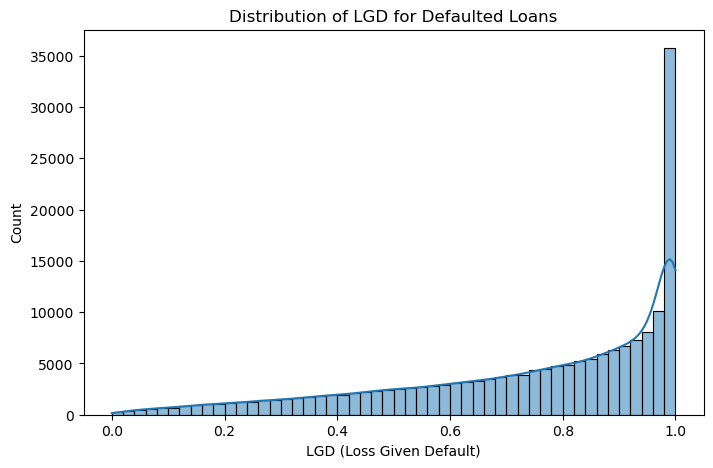


Gradient Boosting Regressor Test Results
RMSE: 0.1969
MAE:  0.1482
R^2:  0.3802


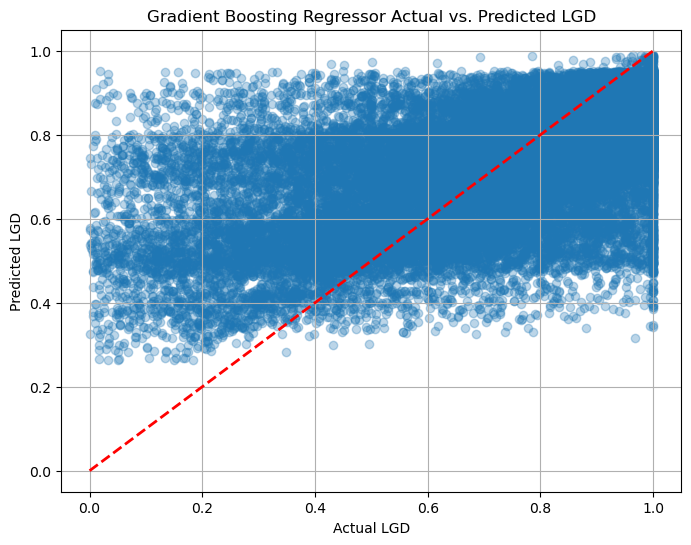


Gradient Boosting Regressor Cross-Validation Metrics (4-fold)
Mean RMSE: 0.1966
Mean MAE:  0.1480
Mean R2:   0.3744

Random Forest Regressor Test Results
RMSE: 0.1963
MAE:  0.1427
R^2:  0.3840


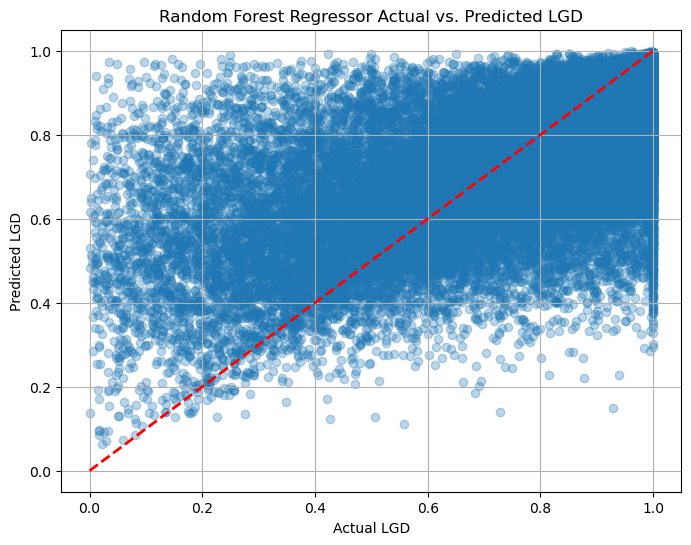


Random Forest Regressor Cross-Validation Metrics (4-fold)
Mean RMSE: 0.1962
Mean MAE:  0.1425
Mean R2:   0.3770

XGBoost Regressor Test Results
RMSE: 0.1925
MAE:  0.1414
R^2:  0.4077


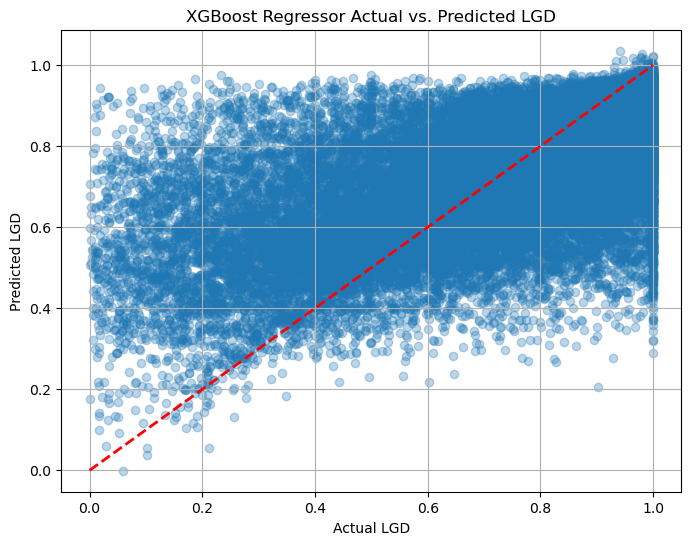


XGBoost Regressor Cross-Validation Metrics (4-fold)
Mean RMSE: 0.1924
Mean MAE:  0.1417
Mean R2:   0.4005


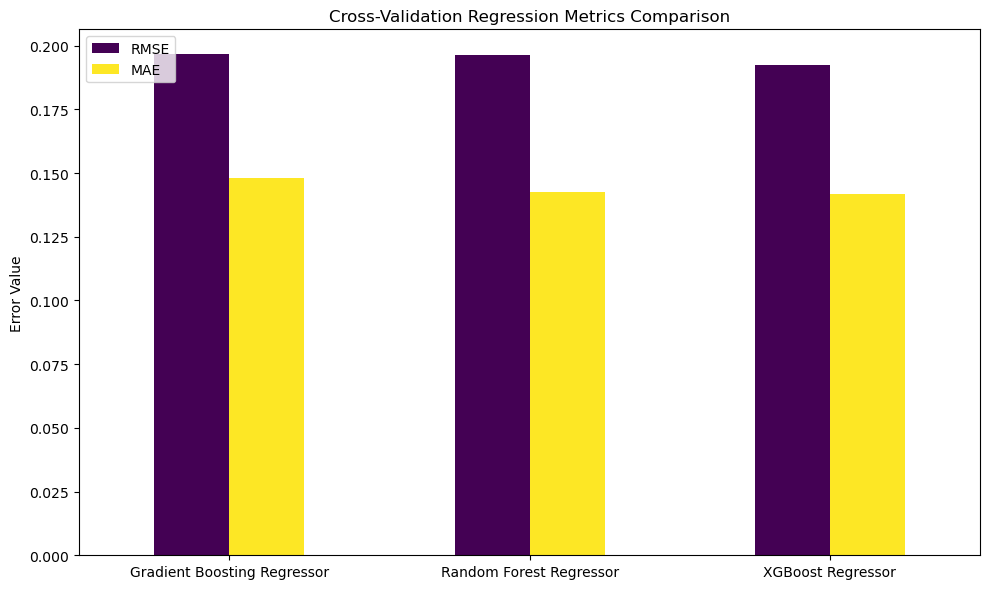

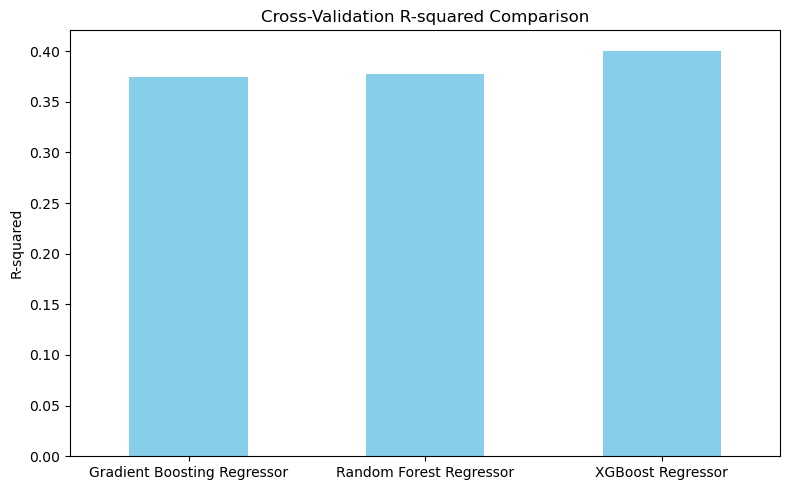

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, KFold # Use KFold for regression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Regression metrics
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor # Regression models
from xgboost import XGBRegressor # Regression model for XGBoost
import shap # For interpretability

df = pd.read_csv('/Users/caitlyndinh/ai-academy/FinalProject/merged_with_naics.csv', low_memory=False)

# Define Loss Given Default (LGD) Target

df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'], errors='coerce')
df['ChargeOffDate'] = pd.to_datetime(df['ChargeOffDate'], errors='coerce')

df['GrossChargeOffAmount'] = pd.to_numeric(df['GrossChargeOffAmount'], errors='coerce').fillna(0)
df['GrossApproval'] = pd.to_numeric(df['GrossApproval'], errors='coerce').fillna(0) # Keep 0 to avoid division by zero later

# Create a 'Defaulted' indicator (1 if charged off, 0 otherwise)
df['Defaulted'] = df['ChargeOffDate'].notna().astype(int)

# Calculate Loss Given Default (LGD)
df['LGD'] = np.where(
    (df['Defaulted'] == 1) & (df['GrossApproval'] > 0),
    df['GrossChargeOffAmount'] / df['GrossApproval'],
    np.nan # Set LGD to NaN for non-defaults or if GrossApproval is 0
)

# Filter for defaulted loans to analyze LGD
df_lgd = df[df['LGD'].notna()].copy()

# Ensure LGD is between 0 and 1
df_lgd['LGD'] = np.clip(df_lgd['LGD'], 0, 1)

print("LGD distribution (for defaulted loans):")
print(df_lgd['LGD'].describe())
plt.figure(figsize=(8, 5))
sns.histplot(df_lgd['LGD'], bins=50, kde=True)
plt.title('Distribution of LGD for Defaulted Loans')
plt.xlabel('LGD (Loss Given Default)')
plt.ylabel('Count')
plt.show()


# Feature Engineering for LGD

df_lgd['ApprovalYear'] = df_lgd['ApprovalDate'].dt.year
df_lgd['ApprovalMonth'] = df_lgd['ApprovalDate'].dt.month

features = [
    'Program', 'Subprogram', 'GrossApproval', 'SBAGuaranteedApproval',
    'InitialInterestRate', 'FixedOrVariableInterestInd', 'TermInMonths',
    'BusinessType', 'BusinessAge', 'CollateralInd', 'RevolverStatus', 'JobsSupported',
    'ProjectState', 'ApprovalYear', 'ApprovalMonth'
]

X = df_lgd[features].copy()
y = df_lgd['LGD']

X = X.drop(columns=['ApprovalDate'], errors='ignore') 

numeric_features = [
    'GrossApproval', 'SBAGuaranteedApproval', 'InitialInterestRate',
    'TermInMonths', 'JobsSupported', 'ApprovalYear', 'ApprovalMonth'
]

categorical_features = [col for col in X.columns if col not in numeric_features]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Train / Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Helper Functions for Regression
metrics_dict = {}
cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)

def cross_val_metrics_reg(model, model_name):
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    # Use regression scoring metrics
    scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
    scores = cross_validate(clf, X_train, y_train, cv=cv_reg, scoring=scoring, n_jobs=-1)

    metrics_dict[model_name] = {
        'RMSE': np.sqrt(-scores['test_neg_mean_squared_error']).mean(), # Convert back to positive RMSE
        'MAE': -scores['test_neg_mean_absolute_error'].mean(), # Convert back to positive MAE
        'R2': scores['test_r2'].mean()
    }

    print(f"\n{model_name} Cross-Validation Metrics (4-fold)")
    print("=" * 55)
    print(f"Mean RMSE: {metrics_dict[model_name]['RMSE']:.4f}")
    print(f"Mean MAE:  {metrics_dict[model_name]['MAE']:.4f}")
    print(f"Mean R2:   {metrics_dict[model_name]['R2']:.4f}")

def train_and_evaluate_reg(model, model_name):
    reg = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    # Evaluate using regression metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name} Test Results")
    print("=" * 50)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R^2:  {r2:.4f}")

    # Plot actual vs. predicted (useful for regression)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # Diagonal line for perfect prediction
    plt.xlabel('Actual LGD')
    plt.ylabel('Predicted LGD')
    plt.title(f'{model_name} Actual vs. Predicted LGD')
    plt.grid(True)
    plt.show()

    # Cross-validation
    cross_val_metrics_reg(model, model_name)


def plot_metrics_comparison_reg(metrics_dict):
    metrics_df = pd.DataFrame(metrics_dict).T
    # Assuming RMSE, MAE, R2 are the keys in metrics_dict values
    metrics_df[['RMSE', 'MAE']].plot(kind='bar', figsize=(10, 6), colormap='viridis')
    plt.title(f"Cross-Validation Regression Metrics Comparison")
    plt.ylabel("Error Value")
    plt.xticks(rotation=0)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    metrics_df['R2'].plot(kind='bar', figsize=(8, 5), color='skyblue')
    plt.title(f"Cross-Validation R-squared Comparison")
    plt.ylabel("R-squared")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Train & Evaluate Regression Models
train_and_evaluate_reg(GradientBoostingRegressor(n_estimators=100, random_state=42), "Gradient Boosting Regressor")
train_and_evaluate_reg(RandomForestRegressor(n_estimators=75, random_state=42, n_jobs=-1), "Random Forest Regressor")
train_and_evaluate_reg(XGBRegressor(n_estimators=75, objective='reg:squarederror', # 'reg:squarederror' for regression
                                    random_state=42, n_jobs=-1), "XGBoost Regressor")

# Compare CV metrics
plot_metrics_comparison_reg(metrics_dict)

Expected Loss

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, # Regression metrics
    classification_report, roc_auc_score, confusion_matrix # Classification metrics
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
import shap # For interpretability (will keep it commented out for now as per your request)

# --- Configuration ---
H = 48  # Horizon in months for default prediction

df = pd.read_csv('/Users/caitlyndinh/ai-academy/FinalProject/merged_with_naics.csv', low_memory=False)

# Prepare Target Variables (PD and LGD)

# Ensure date columns are datetime
df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'], errors='coerce')
df['ChargeOffDate'] = pd.to_datetime(df['ChargeOffDate'], errors='coerce')

# Calculate months to default
months_to_default = (df['ChargeOffDate'] - df['ApprovalDate']).dt.days / 30.4375

# PD Target: Default_48m (1 if default within H months, 0 otherwise)
df[f'Default_{H}m'] = ((~months_to_default.isna()) & (months_to_default <= H)).astype(int)

# Drop rows where target is NaN (if any)
df = df.dropna(subset=[f'Default_{H}m'])

print(f"Original Target distribution for {H}-month horizon (PD):")
print(df[f'Default_{H}m'].value_counts())

# Convert relevant columns to numeric for LGD calculation
df['GrossChargeOffAmount'] = pd.to_numeric(df['GrossChargeOffAmount'], errors='coerce').fillna(0)
df['GrossApproval'] = pd.to_numeric(df['GrossApproval'], errors='coerce').fillna(0) # Fill 0 for safety

# Calculate Loss Given Default (LGD)
df['LGD'] = np.where(
    (df[f'Default_{H}m'] == 1) & (df['GrossApproval'] > 0), 
    df['GrossChargeOffAmount'] / df['GrossApproval'],
    np.nan 
)

# Clamp LGD values between 0 and 1
df['LGD'] = np.clip(df['LGD'], 0, 1)

# Data Balancing for PD Model Training (Undersampling)

defaults_pd = df[df[f'Default_{H}m'] == 1].copy()
non_defaults_pd = df[df[f'Default_{H}m'] == 0].copy()

# Determine the size of the minority class for PD balancing
minority_class_size_pd = len(defaults_pd)

if len(non_defaults_pd) > minority_class_size_pd:
    non_defaults_sample_pd = non_defaults_pd.sample(n=minority_class_size_pd, random_state=42)
    defaults_sample_pd = defaults_pd # Take all defaults
else:
    # This case is rare, but handles if non_defaults are fewer than defaults
    majority_class_size_pd = len(non_defaults_pd)
    defaults_sample_pd = defaults_pd.sample(n=majority_class_size_pd, random_state=42)
    non_defaults_sample_pd = non_defaults_pd

df_balanced_pd = pd.concat([defaults_sample_pd, non_defaults_sample_pd])

print(f"\nBalanced dataset shape for PD model training: {df_balanced_pd.shape}")
print(df_balanced_pd[f'Default_{H}m'].value_counts())

# Filter for LGD Model Training (Only defaulted loans)
df_lgd_train = df[df['LGD'].notna()].copy()

print(f"\nDataset shape for LGD model training (only defaulted loans): {df_lgd_train.shape}")
print(df_lgd_train['LGD'].describe())

# Remove leakage columns
leakage_cols = ['ChargeOffDate', 'GrossChargeOffAmount', 'PaidInFullDate', 'LoanStatus', 'FirstDisbursementDate']
df = df.drop(columns=[col for col in leakage_cols if col in df.columns])
df_balanced_pd = df_balanced_pd.drop(columns=[col for col in leakage_cols if col in df_balanced_pd.columns])
df_lgd_train = df_lgd_train.drop(columns=[col for col in leakage_cols if col in df_lgd_train.columns])


# Feature Engineering (Common for PD and LGD)
features = [
    'Program', 'Subprogram', 'GrossApproval', 'SBAGuaranteedApproval', 'ApprovalDate', # Keep ApprovalDate here for now
    'InitialInterestRate', 'FixedOrVariableInterestInd', 'TermInMonths',
    'BusinessType', 'BusinessAge', 'CollateralInd', 'RevolverStatus', 'JobsSupported', 'ProjectState'
]

# Convert categorical features to string type for consistency
for temp_df in [df, df_balanced_pd, df_lgd_train]:
    if 'ApprovalDate' in temp_df.columns:
        temp_df['ApprovalDate'] = pd.to_datetime(temp_df['ApprovalDate'], errors='coerce')
        temp_df['ApprovalYear'] = temp_df['ApprovalDate'].dt.year
        temp_df['ApprovalMonth'] = temp_df['ApprovalDate'].dt.month
        temp_df.drop(columns=['ApprovalDate'], inplace=True)

# Update features list to include derived date features and exclude original 'ApprovalDate'
features_final = [f for f in features if f != 'ApprovalDate']
features_final.extend(['ApprovalYear', 'ApprovalMonth'])


numeric_features = ['GrossApproval', 'SBAGuaranteedApproval', 'InitialInterestRate',
                    'TermInMonths', 'JobsSupported', 'ApprovalYear', 'ApprovalMonth']

# Ensure categorical_features correctly reflects the updated features list
categorical_features = [col for col in features_final if col not in numeric_features]

# Preprocessing Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Train / Test Split for PD and LGD
X_full = df[features_final].copy() 
y_pd_full = df[f'Default_{H}m'] 
y_lgd_full = df['LGD'] 

# Split the full dataset, stratifying by PD target
X_train_full, X_test_full, y_train_pd_full, y_test_pd_full, y_train_lgd_full, y_test_lgd_full = \
    train_test_split(X_full, y_pd_full, y_lgd_full, stratify=y_pd_full, test_size=0.2, random_state=42)

# Prepare training data for PD model (using balanced data)
X_train_pd_raw = df_balanced_pd[features_final].copy() # Use features_final here
y_train_pd = df_balanced_pd[f'Default_{H}m']

# Prepare training data for LGD model (using only defaulted loans from the training split)
X_train_lgd_raw = X_train_full[y_train_lgd_full.notna()].copy()
y_train_lgd = y_train_lgd_full[y_train_lgd_full.notna()]


preprocessor.fit(X_train_full)

# Now, transform all datasets using the *fitted* preprocessor
X_train_pd_transformed = preprocessor.transform(X_train_pd_raw)
X_train_lgd_transformed = preprocessor.transform(X_train_lgd_raw)
X_test_full_transformed = preprocessor.transform(X_test_full)
# Also transform the actual LGD test set for plotting/evaluation
X_test_lgd_actual_raw = X_test_full[y_test_lgd_full.notna()].copy()
X_test_lgd_actual_transformed = preprocessor.transform(X_test_lgd_actual_raw)


# Helper Functions (Adapted for PD and LGD)
metrics_dict_pd = {}
metrics_dict_lgd = {}
cv_pd = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) # For PD
cv_lgd = KFold(n_splits=4, shuffle=True, random_state=42) # For LGD

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix ({H}-month Horizon)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_actual_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2) # Diagonal line for perfect prediction
    plt.xlabel('Actual LGD')
    plt.ylabel('Predicted LGD')
    plt.title(f'{model_name} Actual vs. Predicted LGD')
    plt.grid(True)
    plt.show()

# --- PD Model Training and Evaluation ---
def train_and_evaluate_pd(model, model_name):
    clf = Pipeline(steps=[('classifier', model)])
    clf.fit(X_train_pd_transformed, y_train_pd) # Train on balanced PD data (transformed)

    y_pred = clf.predict(X_test_full_transformed) # Predict on the full test set (transformed)
    y_proba = clf.predict_proba(X_test_full_transformed)[:, 1] if hasattr(clf.named_steps['classifier'], "predict_proba") else None
    auc = roc_auc_score(y_test_pd_full, y_proba) if y_proba is not None else None

    print(f"\n--- {model_name} (PD) Test Results ({H}-month Horizon) ---")
    print("=" * 60)
    print(classification_report(y_test_pd_full, y_pred))
    if auc is not None:
        print(f"AUC: {auc:.4f}")

    cm = confusion_matrix(y_test_pd_full, y_pred)
    print("Confusion Matrix:")
    print(cm)
    plot_confusion_matrix(cm, model_name)

    # Cross-validation for PD model (using pre-transformed data for cross_validate)
    temp_clf_cv = Pipeline(steps=[('classifier', model)])
    scoring = ['roc_auc', 'f1', 'accuracy']
    scores = cross_validate(temp_clf_cv, X_train_pd_transformed, y_train_pd, cv=cv_pd, scoring=scoring, n_jobs=-1)
    metrics_dict_pd[model_name] = {
        'AUC': scores['test_roc_auc'].mean(),
        'F1': scores['test_f1'].mean(),
        'Accuracy': scores['test_accuracy'].mean()
    }
    print(f"\n{model_name} (PD) Cross-Validation Metrics (4-fold)")
    print("=" * 55)
    print(f"Mean AUC: {metrics_dict_pd[model_name]['AUC']:.4f}")
    print(f"Mean F1:  {metrics_dict_pd[model_name]['F1']:.4f}")
    print(f"Mean Acc: {metrics_dict_pd[model_name]['Accuracy']:.4f}")

    return clf # Return the trained PD pipeline


# LGD Model Training and Evaluation 
def train_and_evaluate_lgd(model, model_name):
    reg = Pipeline(steps=[('regressor', model)])
    reg.fit(X_train_lgd_transformed, y_train_lgd) # Train only on defaulted loans (transformed)

    y_pred_lgd = reg.predict(X_test_lgd_actual_transformed) # Predict on transformed data

    rmse = np.sqrt(mean_squared_error(y_test_lgd_full[y_test_lgd_full.notna()], y_pred_lgd))
    mae = mean_absolute_error(y_test_lgd_full[y_test_lgd_full.notna()], y_pred_lgd)
    r2 = r2_score(y_test_lgd_full[y_test_lgd_full.notna()], y_pred_lgd)

    print(f"\n--- {model_name} (LGD) Test Results ---")
    print("=" * 50)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R^2:  {r2:.4f}")
    plot_actual_vs_predicted(y_test_lgd_full[y_test_lgd_full.notna()], y_pred_lgd, model_name)

    # Cross-validation for LGD model (using pre-transformed data for cross_validate)
    temp_reg_cv = Pipeline(steps=[('regressor', model)])
    scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
    scores = cross_validate(temp_reg_cv, X_train_lgd_transformed, y_train_lgd, cv=cv_lgd, scoring=scoring, n_jobs=-1)
    metrics_dict_lgd[model_name] = {
        'RMSE': np.sqrt(-scores['test_neg_mean_squared_error']).mean(),
        'MAE': -scores['test_neg_mean_absolute_error'].mean(),
        'R2': scores['test_r2'].mean()
    }
    print(f"\n{model_name} (LGD) Cross-Validation Metrics (4-fold)")
    print("=" * 55)
    print(f"Mean RMSE: {metrics_dict_lgd[model_name]['RMSE']:.4f}")
    print(f"Mean MAE:  {metrics_dict_lgd[model_name]['MAE']:.4f}")
    print(f"Mean R2:   {metrics_dict_lgd[model_name]['R2']:.4f}")

    return reg # Return the trained LGD pipeline


# Train & Evaluate PD and LGD Models
print("\n--- Training PD Model (XGBoost Classifier) ---")
pd_model_pipeline = train_and_evaluate_pd(XGBClassifier(n_estimators=75, eval_metric='logloss', random_state=42, n_jobs=-1), "XGBoost Classifier")

print("\n--- Training LGD Model (XGBoost Regressor) ---")
lgd_model_pipeline = train_and_evaluate_lgd(XGBRegressor(n_estimators=75, objective='reg:squarederror', random_state=42, n_jobs=-1), "XGBoost Regressor")


# Expected Loss (EL) Calculation
print("\n--- Calculating Expected Loss (EL) ---")

# 1. Predict PD for the entire test set

predicted_pd = pd_model_pipeline.predict_proba(X_test_full_transformed)[:, 1]

# 2. Predict LGD for the entire test set

predicted_lgd = lgd_model_pipeline.predict(X_test_full_transformed)

# 3. Define EAD (Exposure at Default)

ead = X_test_full['GrossApproval'].fillna(0).values # Convert to numpy array for element-wise multiplication

# 4. Calculate Expected Loss (EL) for each loan in the test set
expected_loss_per_loan = predicted_pd * predicted_lgd * ead

# Add EL to a DataFrame for easier inspection
el_results_df = X_test_full.copy() # Keep original X_test_full for its columns
el_results_df['Actual_PD'] = y_test_pd_full
el_results_df['Actual_LGD'] = y_test_lgd_full # Will have NaNs for non-defaults
el_results_df['Predicted_PD'] = predicted_pd
el_results_df['Predicted_LGD'] = predicted_lgd
el_results_df['EAD'] = ead
el_results_df['Expected_Loss'] = expected_loss_per_loan

print("\nSample of Expected Loss results per loan (Test Set):")
print(el_results_df[['Predicted_PD', 'Predicted_LGD', 'EAD', 'Expected_Loss', 'Actual_PD', 'Actual_LGD']].head(10))

# 5. Aggregate Portfolio-Level Expected Loss
portfolio_expected_loss = el_results_df['Expected_Loss'].sum()
print(f"\nTotal Portfolio Expected Loss (Test Set): ${portfolio_expected_loss:,.2f}")

# You can also calculate average Expected Loss per loan
average_expected_loss_per_loan = el_results_df['Expected_Loss'].mean()
print(f"Average Expected Loss per loan (Test Set): ${average_expected_loss_per_loan:,.2f}")

# Optional: Visualize Expected Loss Distribution
plt.figure(figsize=(10, 6))
sns.histplot(el_results_df['Expected_Loss'], bins=50, kde=True)
plt.title('Distribution of Expected Loss per Loan (Test Set)')
plt.xlabel('Expected Loss ($)')
plt.ylabel('Number of Loans')
plt.yscale('log') # Often useful for skewed distributions
plt.show()

# Optional: Compare CV metrics for PD and LGD models
print("\n--- Cross-Validation Metrics Summary ---")
print("\nPD Model Metrics:")
print(pd.DataFrame(metrics_dict_pd).T)
print("\nLGD Model Metrics:")
print(pd.DataFrame(metrics_dict_lgd).T)


Threshold test

Original Target distribution for 48-month horizon (PD):
Default_48m
0    1464285
1      83993
Name: count, dtype: int64

Balanced dataset shape for PD model training: (167986, 45)
Default_48m
1    83993
0    83993
Name: count, dtype: int64

Dataset shape for LGD model training (only defaulted loans): (83993, 45)
count    83993.000000
mean         0.857247
std          0.177532
min          0.000000
25%          0.794764
50%          0.920913
75%          0.988322
max          1.000000
Name: LGD, dtype: float64

--- Training PD Model (XGBoost Classifier) ---

--- XGBoost Classifier (PD) Test Results (48-month Horizon) ---
AUC: 0.9738 (using default 0.5 threshold for report below)
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    292857
           1       0.34      0.95      0.50     16799

    accuracy                           0.90    309656
   macro avg       0.67      0.92      0.72    309656
weighted avg       0.96      0.90      0

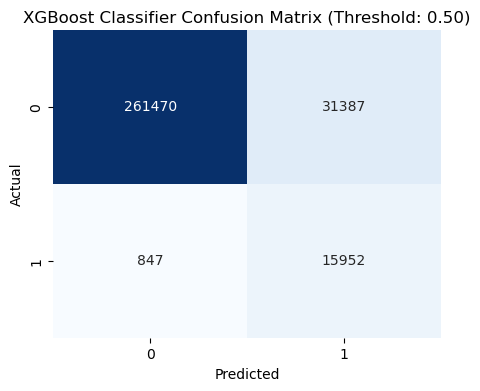


XGBoost Classifier (PD) Cross-Validation Metrics (4-fold)
Mean AUC: 0.9718
Mean F1:  0.9198
Mean Acc: 0.9178

--- Training LGD Model (XGBoost Regressor) ---

--- XGBoost Regressor (LGD) Test Results ---
RMSE: 0.1518
MAE:  0.0994
R^2:  0.2808


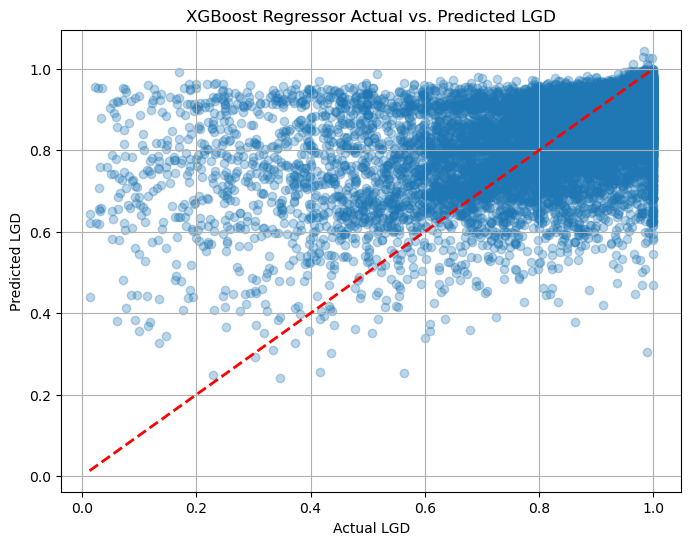


XGBoost Regressor (LGD) Cross-Validation Metrics (4-fold)
Mean RMSE: 0.1493
Mean MAE:  0.0983
Mean R2:   0.2894

--- Calculating Expected Loss (EL) ---

Sample of Expected Loss results per loan (Test Set):
         Predicted_PD  Predicted_LGD       EAD  Expected_Loss  Actual_PD  \
1249976      0.963190       0.869939   10000.0    8379.164934          0   
477545       0.013272       0.916377   35000.0     425.680527          0   
1410228      0.938590       0.925498   15000.0   13029.943407          1   
974126       0.007199       0.905087   50000.0     325.798849          0   
149537       0.097229       0.882468  250000.0   21450.325847          0   
430910       0.878756       0.867004  150000.0  114282.748103          0   
1410045      0.033154       0.800013  126500.0    3355.268547          0   
471205       0.717817       0.539493  130500.0   50537.074775          1   
163515       0.000297       0.532844  625000.0      98.995351          0   
268243       0.000915       0.675

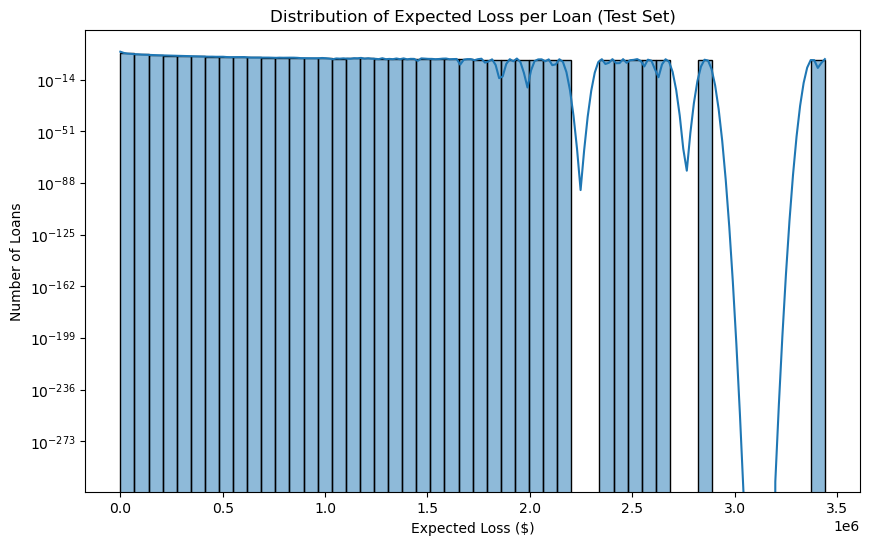


--- Cross-Validation Metrics Summary ---

PD Model Metrics:
                         AUC        F1  Accuracy
XGBoost Classifier  0.971838  0.919756  0.917809

LGD Model Metrics:
                       RMSE       MAE        R2
XGBoost Regressor  0.149341  0.098328  0.289422

--- Experimenting with PD Thresholds to Reduce False Positives ---


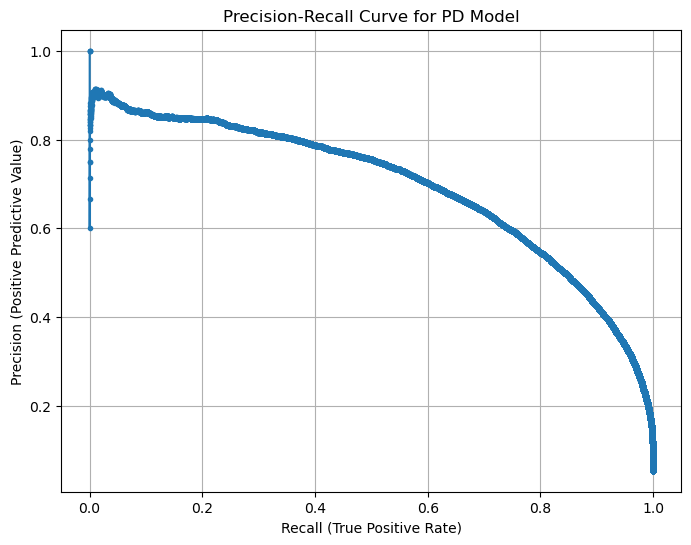


--- XGBoost Classifier (PD) Test Results with Threshold: 0.50 ---
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    292857
           1       0.34      0.95      0.50     16799

    accuracy                           0.90    309656
   macro avg       0.67      0.92      0.72    309656
weighted avg       0.96      0.90      0.92    309656

Confusion Matrix:
[[261470  31387]
 [   847  15952]]


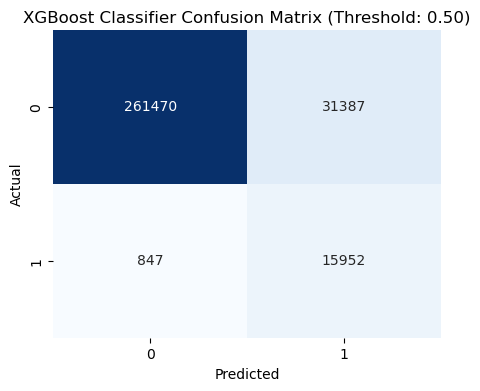

False Positives (FP): 31387
False Negatives (FN): 847
Precision (Class 1): 0.3370
Recall (Class 1): 0.9496

--- XGBoost Classifier (PD) Test Results with Threshold: 0.60 ---
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    292857
           1       0.38      0.93      0.54     16799

    accuracy                           0.91    309656
   macro avg       0.69      0.92      0.75    309656
weighted avg       0.96      0.91      0.93    309656

Confusion Matrix:
[[267497  25360]
 [  1217  15582]]


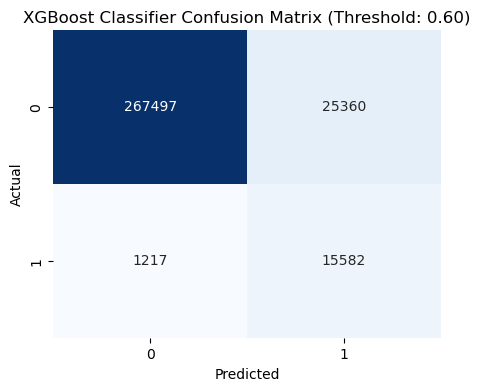

False Positives (FP): 25360
False Negatives (FN): 1217
Precision (Class 1): 0.3806
Recall (Class 1): 0.9276

--- XGBoost Classifier (PD) Test Results with Threshold: 0.70 ---
              precision    recall  f1-score   support

           0       0.99      0.94      0.96    292857
           1       0.44      0.89      0.59     16799

    accuracy                           0.93    309656
   macro avg       0.72      0.91      0.78    309656
weighted avg       0.96      0.93      0.94    309656

Confusion Matrix:
[[273953  18904]
 [  1881  14918]]


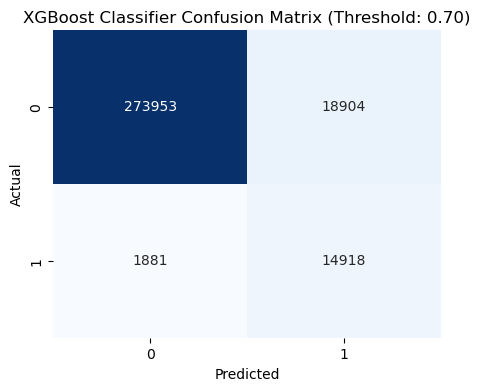

False Positives (FP): 18904
False Negatives (FN): 1881
Precision (Class 1): 0.4411
Recall (Class 1): 0.8880

--- XGBoost Classifier (PD) Test Results with Threshold: 0.80 ---
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    292857
           1       0.53      0.81      0.64     16799

    accuracy                           0.95    309656
   macro avg       0.76      0.89      0.81    309656
weighted avg       0.96      0.95      0.96    309656

Confusion Matrix:
[[280951  11906]
 [  3156  13643]]


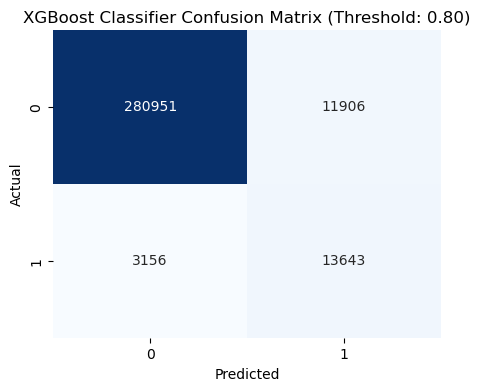

False Positives (FP): 11906
False Negatives (FN): 3156
Precision (Class 1): 0.5340
Recall (Class 1): 0.8121

--- XGBoost Classifier (PD) Test Results with Threshold: 0.90 ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    292857
           1       0.66      0.66      0.66     16799

    accuracy                           0.96    309656
   macro avg       0.82      0.82      0.82    309656
weighted avg       0.96      0.96      0.96    309656

Confusion Matrix:
[[287164   5693]
 [  5656  11143]]


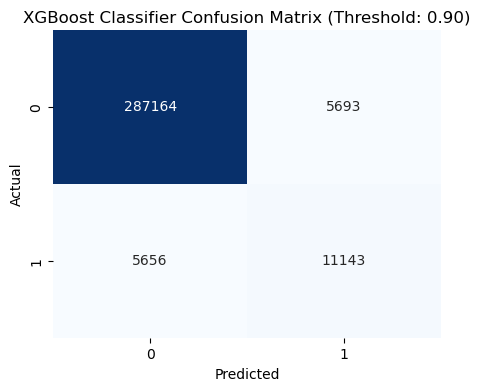

False Positives (FP): 5693
False Negatives (FN): 5656
Precision (Class 1): 0.6619
Recall (Class 1): 0.6633


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, # Regression metrics
    classification_report, roc_auc_score, confusion_matrix, # Classification metrics
    precision_recall_curve, auc # For threshold analysis
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
import shap 

# Configuration 
H = 48  # Horizon in months for default prediction

df = pd.read_csv('/Users/caitlyndinh/ai-academy/FinalProject/merged_with_naics.csv', low_memory=False)


# Ensure date columns are datetime
df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'], errors='coerce')
df['ChargeOffDate'] = pd.to_datetime(df['ChargeOffDate'], errors='coerce')

# Calculate months to default
months_to_default = (df['ChargeOffDate'] - df['ApprovalDate']).dt.days / 30.4375

# PD Target: Default_48m (1 if default within H months, 0 otherwise)
df[f'Default_{H}m'] = ((~months_to_default.isna()) & (months_to_default <= H)).astype(int)

# Drop rows where target is NaN (if any)
df = df.dropna(subset=[f'Default_{H}m'])

print(f"Original Target distribution for {H}-month horizon (PD):")
print(df[f'Default_{H}m'].value_counts())

# Convert relevant columns to numeric for LGD calculation
df['GrossChargeOffAmount'] = pd.to_numeric(df['GrossChargeOffAmount'], errors='coerce').fillna(0)
df['GrossApproval'] = pd.to_numeric(df['GrossApproval'], errors='coerce').fillna(0) # Fill 0 for safety

# LGD Target: Loss Given Default (ChargeOffAmount / GrossApproval)
df['LGD'] = np.where(
    (df[f'Default_{H}m'] == 1) & (df['GrossApproval'] > 0), 
    df['GrossChargeOffAmount'] / df['GrossApproval'],
    np.nan 
)

# Clamp LGD values between 0 and 1
df['LGD'] = np.clip(df['LGD'], 0, 1)

# Data Balancing for PD Model Training (Undersampling)
defaults_pd = df[df[f'Default_{H}m'] == 1].copy()
non_defaults_pd = df[df[f'Default_{H}m'] == 0].copy()

# Determine the size of the minority class for PD balancing
minority_class_size_pd = len(defaults_pd)

if len(non_defaults_pd) > minority_class_size_pd:
    non_defaults_sample_pd = non_defaults_pd.sample(n=minority_class_size_pd, random_state=42)
    defaults_sample_pd = defaults_pd # Take all defaults
else:
    # This case is rare, but handles if non_defaults are fewer than defaults
    majority_class_size_pd = len(non_defaults_pd)
    defaults_sample_pd = defaults_pd.sample(n=majority_class_size_pd, random_state=42)
    non_defaults_sample_pd = non_defaults_pd

df_balanced_pd = pd.concat([defaults_sample_pd, non_defaults_sample_pd])

print(f"\nBalanced dataset shape for PD model training: {df_balanced_pd.shape}")
print(df_balanced_pd[f'Default_{H}m'].value_counts())

# Filter for LGD Model Training (Only defaulted loans)
df_lgd_train = df[df['LGD'].notna()].copy()

print(f"\nDataset shape for LGD model training (only defaulted loans): {df_lgd_train.shape}")
print(df_lgd_train['LGD'].describe())

# Remove leakage columns
leakage_cols = ['ChargeOffDate', 'GrossChargeOffAmount', 'PaidInFullDate', 'LoanStatus', 'FirstDisbursementDate']
# Apply removal to both the full df and the LGD-specific df
df = df.drop(columns=[col for col in leakage_cols if col in df.columns])
df_balanced_pd = df_balanced_pd.drop(columns=[col for col in leakage_cols if col in df_balanced_pd.columns])
df_lgd_train = df_lgd_train.drop(columns=[col for col in leakage_cols if col in df_lgd_train.columns])


# Feature Engineering 
features = [
    'Program', 'Subprogram', 'GrossApproval', 'SBAGuaranteedApproval', 'ApprovalDate', # Keep ApprovalDate here for now
    'InitialInterestRate', 'FixedOrVariableInterestInd', 'TermInMonths',
    'BusinessType', 'BusinessAge', 'CollateralInd', 'RevolverStatus', 'JobsSupported', 'ProjectState'
]


for temp_df in [df, df_balanced_pd, df_lgd_train]:
    if 'ApprovalDate' in temp_df.columns:
        temp_df['ApprovalDate'] = pd.to_datetime(temp_df['ApprovalDate'], errors='coerce')
        temp_df['ApprovalYear'] = temp_df['ApprovalDate'].dt.year
        temp_df['ApprovalMonth'] = temp_df['ApprovalDate'].dt.month
        temp_df.drop(columns=['ApprovalDate'], inplace=True)

features_final = [f for f in features if f != 'ApprovalDate']
features_final.extend(['ApprovalYear', 'ApprovalMonth'])


numeric_features = ['GrossApproval', 'SBAGuaranteedApproval', 'InitialInterestRate',
                    'TermInMonths', 'JobsSupported', 'ApprovalYear', 'ApprovalMonth']

# Ensure categorical_features correctly reflects the updated features list
categorical_features = [col for col in features_final if col not in numeric_features]

# Preprocessing Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Train / Test Split for PD and LGD
X_full = df[features_final].copy() 
y_pd_full = df[f'Default_{H}m'] 
y_lgd_full = df['LGD'] 

# Split the full dataset, stratifying by PD target
X_train_full, X_test_full, y_train_pd_full, y_test_pd_full, y_train_lgd_full, y_test_lgd_full = \
    train_test_split(X_full, y_pd_full, y_lgd_full, stratify=y_pd_full, test_size=0.2, random_state=42)

# Prepare training data for PD model (using balanced data)
X_train_pd_raw = df_balanced_pd[features_final].copy() 
y_train_pd = df_balanced_pd[f'Default_{H}m']

# Prepare training data for LGD model (using only defaulted loans from the training split)
X_train_lgd_raw = X_train_full[y_train_lgd_full.notna()].copy()
y_train_lgd = y_train_lgd_full[y_train_lgd_full.notna()]


preprocessor.fit(X_train_full)

# Now, transform all datasets using the *fitted* preprocessor
X_train_pd_transformed = preprocessor.transform(X_train_pd_raw)
X_train_lgd_transformed = preprocessor.transform(X_train_lgd_raw)
X_test_full_transformed = preprocessor.transform(X_test_full)
# Also transform the actual LGD test set for plotting/evaluation
X_test_lgd_actual_raw = X_test_full[y_test_lgd_full.notna()].copy()
X_test_lgd_actual_transformed = preprocessor.transform(X_test_lgd_actual_raw)


# Helper Functions (Adapted for PD and LGD)
metrics_dict_pd = {}
metrics_dict_lgd = {}
cv_pd = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # For PD
cv_lgd = KFold(n_splits=5, shuffle=True, random_state=42) # For LGD

def plot_confusion_matrix(cm, model_name, threshold=0.5):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix (Threshold: {threshold:.2f})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_actual_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2) # Diagonal line for perfect prediction
    plt.xlabel('Actual LGD')
    plt.ylabel('Predicted LGD')
    plt.title(f'{model_name} Actual vs. Predicted LGD')
    plt.grid(True)
    plt.show()

# PD Model Training and Evaluation
def train_and_evaluate_pd(model, model_name):
    clf = Pipeline(steps=[('classifier', model)])
    clf.fit(X_train_pd_transformed, y_train_pd) # Train on balanced PD data (transformed)

    y_proba = clf.predict_proba(X_test_full_transformed)[:, 1]
    auc = roc_auc_score(y_test_pd_full, y_proba)

    print(f"\n--- {model_name} (PD) Test Results ({H}-month Horizon) ---")
    print("=" * 60)
    print(f"AUC: {auc:.4f} (using default 0.5 threshold for report below)")

    # Evaluate with default 0.5 threshold
    y_pred_default_threshold = (y_proba >= 0.5).astype(int)
    print(classification_report(y_test_pd_full, y_pred_default_threshold))
    cm_default = confusion_matrix(y_test_pd_full, y_pred_default_threshold)
    print("Confusion Matrix (Default Threshold 0.5):")
    print(cm_default)
    plot_confusion_matrix(cm_default, model_name, threshold=0.5)

    # Cross-validation for PD model (using pre-transformed data for cross_validate)
    temp_clf_cv = Pipeline(steps=[('classifier', model)])
    scoring = ['roc_auc', 'f1', 'accuracy']
    scores = cross_validate(temp_clf_cv, X_train_pd_transformed, y_train_pd, cv=cv_pd, scoring=scoring, n_jobs=-1)
    metrics_dict_pd[model_name] = {
        'AUC': scores['test_roc_auc'].mean(),
        'F1': scores['test_f1'].mean(),
        'Accuracy': scores['test_accuracy'].mean()
    }
    print(f"\n{model_name} (PD) Cross-Validation Metrics (4-fold)")
    print("=" * 55)
    print(f"Mean AUC: {metrics_dict_pd[model_name]['AUC']:.4f}")
    print(f"Mean F1:  {metrics_dict_pd[model_name]['F1']:.4f}")
    print(f"Mean Acc: {metrics_dict_pd[model_name]['Accuracy']:.4f}")

    return clf # Return the trained PD pipeline


# --- LGD Model Training and Evaluation ---
def train_and_evaluate_lgd(model, model_name):
    reg = Pipeline(steps=[('regressor', model)])
    reg.fit(X_train_lgd_transformed, y_train_lgd) 

    y_pred_lgd = reg.predict(X_test_lgd_actual_transformed) # Predict on transformed data

    rmse = np.sqrt(mean_squared_error(y_test_lgd_full[y_test_lgd_full.notna()], y_pred_lgd))
    mae = mean_absolute_error(y_test_lgd_full[y_test_lgd_full.notna()], y_pred_lgd)
    r2 = r2_score(y_test_lgd_full[y_test_lgd_full.notna()], y_pred_lgd)

    print(f"\n--- {model_name} (LGD) Test Results ---")
    print("=" * 50)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R^2:  {r2:.4f}")
    plot_actual_vs_predicted(y_test_lgd_full[y_test_lgd_full.notna()], y_pred_lgd, model_name)

    # Cross-validation for LGD model (using pre-transformed data for cross_validate)
    temp_reg_cv = Pipeline(steps=[('regressor', model)])
    scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
    scores = cross_validate(temp_reg_cv, X_train_lgd_transformed, y_train_lgd, cv=cv_lgd, scoring=scoring, n_jobs=-1)
    metrics_dict_lgd[model_name] = {
        'RMSE': np.sqrt(-scores['test_neg_mean_squared_error']).mean(),
        'MAE': -scores['test_neg_mean_absolute_error'].mean(),
        'R2': scores['test_r2'].mean()
    }
    print(f"\n{model_name} (LGD) Cross-Validation Metrics (4-fold)")
    print("=" * 55)
    print(f"Mean RMSE: {metrics_dict_lgd[model_name]['RMSE']:.4f}")
    print(f"Mean MAE:  {metrics_dict_lgd[model_name]['MAE']:.4f}")
    print(f"Mean R2:   {metrics_dict_lgd[model_name]['R2']:.4f}")

    return reg # Return the trained LGD pipeline

# New Function to Evaluate PD with Custom Threshold 
def evaluate_pd_with_threshold(pd_pipeline, model_name, threshold, y_true, X_transformed):
    y_proba = pd_pipeline.predict_proba(X_transformed)[:, 1]
    y_pred_threshold = (y_proba >= threshold).astype(int)

    print(f"\n--- {model_name} (PD) Test Results with Threshold: {threshold:.2f} ---")
    print("=" * 70)
    print(classification_report(y_true, y_pred_threshold))
    cm = confusion_matrix(y_true, y_pred_threshold)
    print("Confusion Matrix:")
    print(cm)
    plot_confusion_matrix(cm, model_name, threshold=threshold)
    tn, fp, fn, tp = cm.ravel()
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"Precision (Class 1): {tp / (tp + fp):.4f}")
    print(f"Recall (Class 1): {tp / (tp + fn):.4f}")


# Train & Evaluate PD and LGD Models
print("\n--- Training PD Model (XGBoost Classifier) ---")
pd_model_pipeline = train_and_evaluate_pd(XGBClassifier(n_estimators=75, eval_metric='logloss', random_state=42, n_jobs=-1), "XGBoost Classifier")

print("\n--- Training LGD Model (XGBoost Regressor) ---")
lgd_model_pipeline = train_and_evaluate_lgd(XGBRegressor(n_estimators=75, objective='reg:squarederror', random_state=42, n_jobs=-1), "XGBoost Regressor")


# Expected Loss (EL) Calculation
print("\n--- Calculating Expected Loss (EL) ---")

# 1. Predict PD for the entire test set
predicted_pd = pd_model_pipeline.predict_proba(X_test_full_transformed)[:, 1]

# 2. Predict LGD for the entire test set
predicted_lgd = lgd_model_pipeline.predict(X_test_full_transformed)

# 3. Define EAD (Exposure at Default)
ead = X_test_full['GrossApproval'].fillna(0).values # Convert to numpy array for element-wise multiplication

# 4. Calculate Expected Loss (EL) for each loan in the test set
expected_loss_per_loan = predicted_pd * predicted_lgd * ead

# Add EL to a DataFrame for easier inspection
el_results_df = X_test_full.copy() # Keep original X_test_full for its columns
el_results_df['Actual_PD'] = y_test_pd_full
el_results_df['Actual_LGD'] = y_test_lgd_full # Will have NaNs for non-defaults
el_results_df['Predicted_PD'] = predicted_pd
el_results_df['Predicted_LGD'] = predicted_lgd
el_results_df['EAD'] = ead
el_results_df['Expected_Loss'] = expected_loss_per_loan

print("\nSample of Expected Loss results per loan (Test Set):")
print(el_results_df[['Predicted_PD', 'Predicted_LGD', 'EAD', 'Expected_Loss', 'Actual_PD', 'Actual_LGD']].head(10))

# 5. Aggregate Portfolio-Level Expected Loss
portfolio_expected_loss = el_results_df['Expected_Loss'].sum()
print(f"\nTotal Portfolio Expected Loss (Test Set): ${portfolio_expected_loss:,.2f}")

# You can also calculate average Expected Loss per loan
average_expected_loss_per_loan = el_results_df['Expected_Loss'].mean()
print(f"Average Expected Loss per loan (Test Set): ${average_expected_loss_per_loan:,.2f}")

# Visualize Expected Loss Distribution
plt.figure(figsize=(10, 6))
sns.histplot(el_results_df['Expected_Loss'], bins=50, kde=True)
plt.title('Distribution of Expected Loss per Loan (Test Set)')
plt.xlabel('Expected Loss ($)')
plt.ylabel('Number of Loans')
plt.yscale('log') # Often useful for skewed distributions
plt.show()

# Compare CV metrics for PD and LGD models
print("\n--- Cross-Validation Metrics Summary ---")
print("\nPD Model Metrics:")
print(pd.DataFrame(metrics_dict_pd).T)
print("\nLGD Model Metrics:")
print(pd.DataFrame(metrics_dict_lgd).T)

# Experiment with PD Thresholds to Reduce False Positives

print("\n--- Experimenting with PD Thresholds to Reduce False Positives ---")

# Get predicted probabilities from the trained PD model
pd_proba_test = pd_model_pipeline.predict_proba(X_test_full_transformed)[:, 1]

# Plot Precision-Recall Curve to visualize trade-offs
precision, recall, thresholds = precision_recall_curve(y_test_pd_full, pd_proba_test)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve for PD Model')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.grid(True)
plt.show()

# Example thresholds to test:
thresholds_to_test = [0.5, 0.6, 0.7, 0.8, 0.9] # Add more as needed

for threshold in thresholds_to_test:
    evaluate_pd_with_threshold(pd_model_pipeline, "XGBoost Classifier", threshold, y_test_pd_full, X_test_full_transformed)



0.9 Threshold for expected loss

Original Target distribution for 48-month horizon (PD):
Default_48m
0    1464285
1      83993
Name: count, dtype: int64

Balanced dataset shape for PD model training: (167986, 45)
Default_48m
1    83993
0    83993
Name: count, dtype: int64

Dataset shape for LGD model training (only defaulted loans): (83993, 45)
count    83993.000000
mean         0.857247
std          0.177532
min          0.000000
25%          0.794764
50%          0.920913
75%          0.988322
max          1.000000
Name: LGD, dtype: float64

--- Training PD Model (XGBoost Classifier) ---

--- XGBoost Classifier (PD) Test Results (48-month Horizon) ---
AUC: 0.9738
Classification Report (Threshold 0.90):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    292857
           1       0.66      0.66      0.66     16799

    accuracy                           0.96    309656
   macro avg       0.82      0.82      0.82    309656
weighted avg       0.96      0.96      0.96    

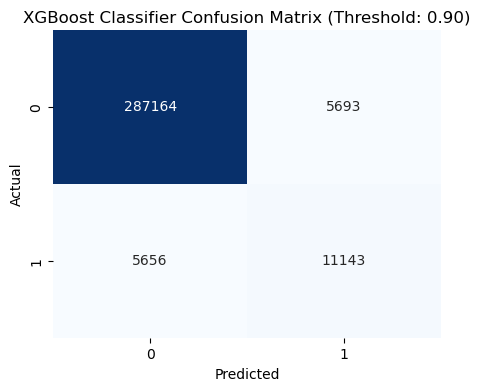


XGBoost Classifier (PD) Cross-Validation Metrics (5-fold)
Mean AUC: 0.9718
Mean F1:  0.9198
Mean Acc: 0.9178

--- Training LGD Model (XGBoost Regressor) ---

--- XGBoost Regressor (LGD) Test Results ---
RMSE: 0.1518
MAE:  0.0994
R^2:  0.2808


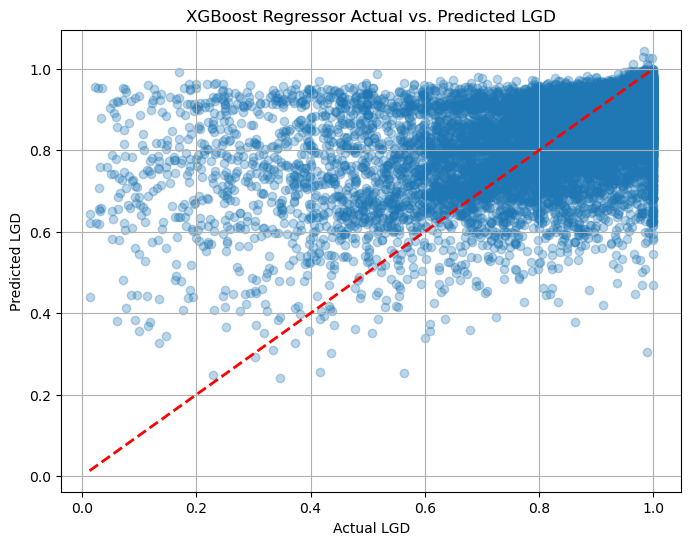


XGBoost Regressor (LGD) Cross-Validation Metrics (5-fold)
Mean RMSE: 0.1493
Mean MAE:  0.0983
Mean R2:   0.2894

--- Calculating Expected Loss (EL) ---

Sample of Expected Loss results per loan (Test Set):
         Predicted_PD_Proba  Predicted_PD_Binary  Predicted_LGD       EAD  \
1249976            0.963190                    1       0.869939   10000.0   
477545             0.013272                    0       0.916377   35000.0   
1410228            0.938590                    1       0.925498   15000.0   
974126             0.007199                    0       0.905087   50000.0   
149537             0.097229                    0       0.882468  250000.0   
430910             0.878756                    0       0.867004  150000.0   
1410045            0.033154                    0       0.800013  126500.0   
471205             0.717817                    0       0.539493  130500.0   
163515             0.000297                    0       0.532844  625000.0   
268243             0.00

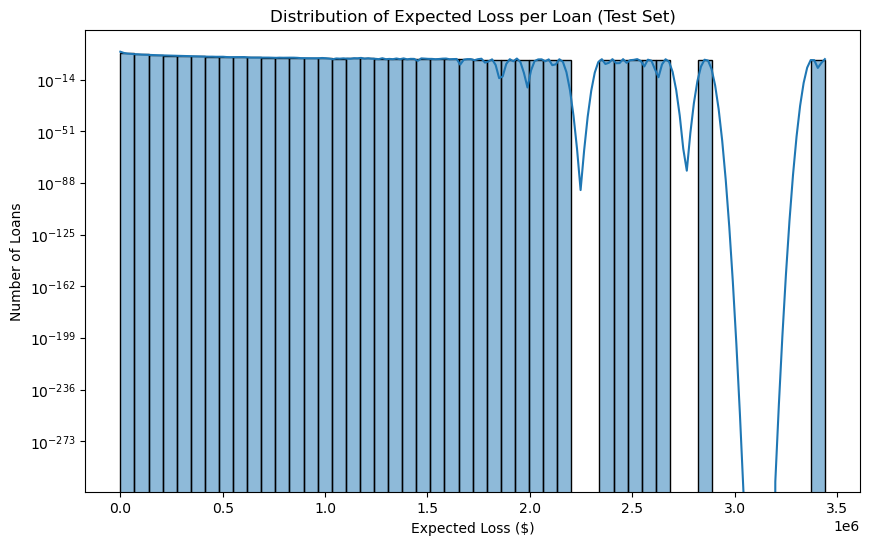


--- Cross-Validation Metrics Summary ---

PD Model Metrics:
                         AUC        F1  Accuracy
XGBoost Classifier  0.971838  0.919756  0.917809

LGD Model Metrics:
                       RMSE       MAE        R2
XGBoost Regressor  0.149341  0.098328  0.289422

--- PD Model Evaluation at Chosen Threshold (0.90) ---

--- XGBoost Classifier (PD) Test Results with Threshold: 0.90 ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    292857
           1       0.66      0.66      0.66     16799

    accuracy                           0.96    309656
   macro avg       0.82      0.82      0.82    309656
weighted avg       0.96      0.96      0.96    309656

Confusion Matrix:
[[287164   5693]
 [  5656  11143]]


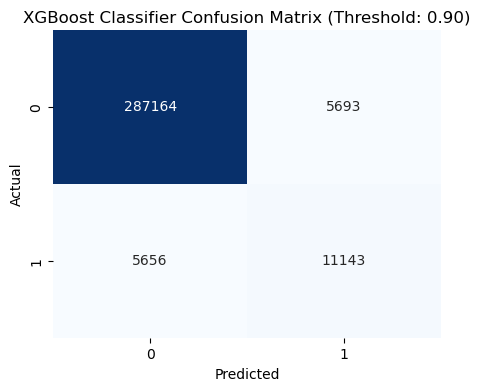

False Positives (FP): 5693
False Negatives (FN): 5656
Precision (Class 1): 0.6619
Recall (Class 1): 0.6633


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, # Regression metrics
    classification_report, roc_auc_score, confusion_matrix # Classification metrics
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

# Configuration 
H = 48  # Horizon in months for default prediction
PD_THRESHOLD = 0.90 # Chosen default threshold for PD model for reporting and binary decisions

df = pd.read_csv('/Users/caitlyndinh/ai-academy/FinalProject/merged_with_naics.csv', low_memory=False)

# Prepare Target Variables (PD and LGD)

# Ensure date columns are datetime
df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'], errors='coerce')
df['ChargeOffDate'] = pd.to_datetime(df['ChargeOffDate'], errors='coerce')

# Calculate months to default
months_to_default = (df['ChargeOffDate'] - df['ApprovalDate']).dt.days / 30.4375

# PD Target: Default_48m (1 if default within H months, 0 otherwise)
df[f'Default_{H}m'] = ((~months_to_default.isna()) & (months_to_default <= H)).astype(int)

# Drop rows where target is NaN (if any)
df = df.dropna(subset=[f'Default_{H}m'])

print(f"Original Target distribution for {H}-month horizon (PD):")
print(df[f'Default_{H}m'].value_counts())

# Convert relevant columns to numeric for LGD calculation
df['GrossChargeOffAmount'] = pd.to_numeric(df['GrossChargeOffAmount'], errors='coerce').fillna(0)
df['GrossApproval'] = pd.to_numeric(df['GrossApproval'], errors='coerce').fillna(0) # Fill 0 for safety

# LGD Target: Loss Given Default (ChargeOffAmount / GrossApproval)
df['LGD'] = np.where(
    (df[f'Default_{H}m'] == 1) & (df['GrossApproval'] > 0), # Only for actual defaults and valid approval
    df['GrossChargeOffAmount'] / df['GrossApproval'],
    np.nan 
)

# Clamp LGD values between 0 and 1
df['LGD'] = np.clip(df['LGD'], 0, 1)

# Data Balancing for PD Model Training (Undersampling)

defaults_pd = df[df[f'Default_{H}m'] == 1].copy()
non_defaults_pd = df[df[f'Default_{H}m'] == 0].copy()

# Determine the size of the minority class for PD balancing
minority_class_size_pd = len(defaults_pd)

if len(non_defaults_pd) > minority_class_size_pd:
    non_defaults_sample_pd = non_defaults_pd.sample(n=minority_class_size_pd, random_state=42)
    defaults_sample_pd = defaults_pd # Take all defaults
else:
    # This case is rare, but handles if non_defaults are fewer than defaults
    majority_class_size_pd = len(non_defaults_pd)
    defaults_sample_pd = defaults_pd.sample(n=majority_class_size_pd, random_state=42)
    non_defaults_sample_pd = non_defaults_pd

df_balanced_pd = pd.concat([defaults_sample_pd, non_defaults_sample_pd])

print(f"\nBalanced dataset shape for PD model training: {df_balanced_pd.shape}")
print(df_balanced_pd[f'Default_{H}m'].value_counts())

# Filter for LGD Model Training (Only defaulted loans)

df_lgd_train = df[df['LGD'].notna()].copy()

print(f"\nDataset shape for LGD model training (only defaulted loans): {df_lgd_train.shape}")
print(df_lgd_train['LGD'].describe())

# Remove leakage columns
leakage_cols = ['ChargeOffDate', 'GrossChargeOffAmount', 'PaidInFullDate', 'LoanStatus', 'FirstDisbursementDate']
# Apply removal to both the full df and the LGD-specific df
df = df.drop(columns=[col for col in leakage_cols if col in df.columns])
df_balanced_pd = df_balanced_pd.drop(columns=[col for col in leakage_cols if col in df_balanced_pd.columns])
df_lgd_train = df_lgd_train.drop(columns=[col for col in leakage_cols if col in df_lgd_train.columns])


# Feature Engineering (Common for PD and LGD)
features = [
    'Program', 'Subprogram', 'GrossApproval', 'SBAGuaranteedApproval', 'ApprovalDate',
    'InitialInterestRate', 'FixedOrVariableInterestInd', 'TermInMonths',
    'BusinessType', 'BusinessAge', 'CollateralInd', 'RevolverStatus', 'JobsSupported', 'ProjectState'
]

# Process ApprovalDate for all relevant dataframes and add derived features
for temp_df in [df, df_balanced_pd, df_lgd_train]:
    if 'ApprovalDate' in temp_df.columns:
        temp_df['ApprovalDate'] = pd.to_datetime(temp_df['ApprovalDate'], errors='coerce')
        temp_df['ApprovalYear'] = temp_df['ApprovalDate'].dt.year
        temp_df['ApprovalMonth'] = temp_df['ApprovalDate'].dt.month
        temp_df.drop(columns=['ApprovalDate'], inplace=True)

# Update features list to include derived date features and exclude original 'ApprovalDate'
features_final = [f for f in features if f != 'ApprovalDate']
features_final.extend(['ApprovalYear', 'ApprovalMonth'])


numeric_features = ['GrossApproval', 'SBAGuaranteedApproval', 'InitialInterestRate',
                    'TermInMonths', 'JobsSupported', 'ApprovalYear', 'ApprovalMonth']

# Ensure categorical_features correctly reflects the updated features list
categorical_features = [col for col in features_final if col not in numeric_features]

# Preprocessing Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Train / Test Split for PD and LGD

X_full = df[features_final].copy() # Use features_final here
y_pd_full = df[f'Default_{H}m'] # PD target for the entire dataset
y_lgd_full = df['LGD'] # LGD target (will have NaNs for non-defaults)

# Split the full dataset, stratifying by PD target
X_train_full, X_test_full, y_train_pd_full, y_test_pd_full, y_train_lgd_full, y_test_lgd_full = \
    train_test_split(X_full, y_pd_full, y_lgd_full, stratify=y_pd_full, test_size=0.2, random_state=42)

# Prepare training data for PD model (using balanced data)
X_train_pd_raw = df_balanced_pd[features_final].copy() # Use features_final here
y_train_pd = df_balanced_pd[f'Default_{H}m']

# Prepare training data for LGD model (using only defaulted loans from the training split)
X_train_lgd_raw = X_train_full[y_train_lgd_full.notna()].copy()
y_train_lgd = y_train_lgd_full[y_train_lgd_full.notna()]


preprocessor.fit(X_train_full)

# Now, transform all datasets using the *fitted* preprocessor
X_train_pd_transformed = preprocessor.transform(X_train_pd_raw)
X_train_lgd_transformed = preprocessor.transform(X_train_lgd_raw)
X_test_full_transformed = preprocessor.transform(X_test_full)
# Also transform the actual LGD test set for plotting/evaluation
X_test_lgd_actual_raw = X_test_full[y_test_lgd_full.notna()].copy()
X_test_lgd_actual_transformed = preprocessor.transform(X_test_lgd_actual_raw)


# Helper Functions (Adapted for PD and LGD)
metrics_dict_pd = {}
metrics_dict_lgd = {}
cv_pd = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # For PD
cv_lgd = KFold(n_splits=5, shuffle=True, random_state=42) # For LGD

def plot_confusion_matrix(cm, model_name, threshold=0.5):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix (Threshold: {threshold:.2f})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def plot_actual_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2) # Diagonal line for perfect prediction
    plt.xlabel('Actual LGD')
    plt.ylabel('Predicted LGD')
    plt.title(f'{model_name} Actual vs. Predicted LGD')
    plt.grid(True)
    plt.show()

# PD Model Training and Evaluation 
def train_and_evaluate_pd(model, model_name):
    clf = Pipeline(steps=[('classifier', model)])
    clf.fit(X_train_pd_transformed, y_train_pd) # Train on balanced PD data (transformed)

    y_proba = clf.predict_proba(X_test_full_transformed)[:, 1]
    auc = roc_auc_score(y_test_pd_full, y_proba)

    print(f"\n--- {model_name} (PD) Test Results ({H}-month Horizon) ---")
    print("=" * 60)
    print(f"AUC: {auc:.4f}")

    # Evaluate with the chosen PD_THRESHOLD
    y_pred_threshold = (y_proba >= PD_THRESHOLD).astype(int)
    print(f"Classification Report (Threshold {PD_THRESHOLD:.2f}):")
    print(classification_report(y_test_pd_full, y_pred_threshold))
    cm_threshold = confusion_matrix(y_test_pd_full, y_pred_threshold)
    print(f"Confusion Matrix (Threshold {PD_THRESHOLD:.2f}):")
    print(cm_threshold)
    plot_confusion_matrix(cm_threshold, model_name, threshold=PD_THRESHOLD)

    # Cross-validation for PD model (using pre-transformed data for cross_validate)
    temp_clf_cv = Pipeline(steps=[('classifier', model)])
    scoring = ['roc_auc', 'f1', 'accuracy']
    scores = cross_validate(temp_clf_cv, X_train_pd_transformed, y_train_pd, cv=cv_pd, scoring=scoring, n_jobs=-1)
    metrics_dict_pd[model_name] = {
        'AUC': scores['test_roc_auc'].mean(),
        'F1': scores['test_f1'].mean(),
        'Accuracy': scores['test_accuracy'].mean()
    }
    print(f"\n{model_name} (PD) Cross-Validation Metrics (5-fold)")
    print("=" * 55)
    print(f"Mean AUC: {metrics_dict_pd[model_name]['AUC']:.4f}")
    print(f"Mean F1:  {metrics_dict_pd[model_name]['F1']:.4f}")
    print(f"Mean Acc: {metrics_dict_pd[model_name]['Accuracy']:.4f}")

    return clf # Return the trained PD pipeline


#  LGD Model Training and Evaluation 
def train_and_evaluate_lgd(model, model_name):
    reg = Pipeline(steps=[('regressor', model)])
    reg.fit(X_train_lgd_transformed, y_train_lgd) # Train only on defaulted loans (transformed)

    # Evaluate on the test set, but only where LGD is available (i.e., actual defaults)
    y_pred_lgd = reg.predict(X_test_lgd_actual_transformed) # Predict on transformed data

    rmse = np.sqrt(mean_squared_error(y_test_lgd_full[y_test_lgd_full.notna()], y_pred_lgd))
    mae = mean_absolute_error(y_test_lgd_full[y_test_lgd_full.notna()], y_pred_lgd)
    r2 = r2_score(y_test_lgd_full[y_test_lgd_full.notna()], y_pred_lgd)

    print(f"\n--- {model_name} (LGD) Test Results ---")
    print("=" * 50)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R^2:  {r2:.4f}")
    plot_actual_vs_predicted(y_test_lgd_full[y_test_lgd_full.notna()], y_pred_lgd, model_name)

    # Cross-validation for LGD model (using pre-transformed data for cross_validate)
    temp_reg_cv = Pipeline(steps=[('regressor', model)])
    scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
    scores = cross_validate(temp_reg_cv, X_train_lgd_transformed, y_train_lgd, cv=cv_lgd, scoring=scoring, n_jobs=-1)
    metrics_dict_lgd[model_name] = {
        'RMSE': np.sqrt(-scores['test_neg_mean_squared_error']).mean(),
        'MAE': -scores['test_neg_mean_absolute_error'].mean(),
        'R2': scores['test_r2'].mean()
    }
    print(f"\n{model_name} (LGD) Cross-Validation Metrics (5-fold)")
    print("=" * 55)
    print(f"Mean RMSE: {metrics_dict_lgd[model_name]['RMSE']:.4f}")
    print(f"Mean MAE:  {metrics_dict_lgd[model_name]['MAE']:.4f}")
    print(f"Mean R2:   {metrics_dict_lgd[model_name]['R2']:.4f}")

    return reg # Return the trained LGD pipeline

# New Function to Evaluate PD with Custom Threshold 
def evaluate_pd_with_threshold(pd_pipeline, model_name, threshold, y_true, X_transformed):
    y_proba = pd_pipeline.predict_proba(X_transformed)[:, 1]
    y_pred_threshold = (y_proba >= threshold).astype(int)

    print(f"\n--- {model_name} (PD) Test Results with Threshold: {threshold:.2f} ---")
    print("=" * 70)
    print(classification_report(y_true, y_pred_threshold))
    cm = confusion_matrix(y_true, y_pred_threshold)
    print("Confusion Matrix:")
    print(cm)
    plot_confusion_matrix(cm, model_name, threshold=threshold)
    # You can also print specific metrics like false positives:
    tn, fp, fn, tp = cm.ravel()
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"Precision (Class 1): {tp / (tp + fp):.4f}")
    print(f"Recall (Class 1): {tp / (tp + fn):.4f}")


# Train & Evaluate PD and LGD Models
print("\n--- Training PD Model (XGBoost Classifier) ---")
pd_model_pipeline = train_and_evaluate_pd(XGBClassifier(n_estimators=75, eval_metric='logloss', random_state=42, n_jobs=-1), "XGBoost Classifier")

print("\n--- Training LGD Model (XGBoost Regressor) ---")
lgd_model_pipeline = train_and_evaluate_lgd(XGBRegressor(n_estimators=75, objective='reg:squarederror', random_state=42, n_jobs=-1), "XGBoost Regressor")


# Expected Loss (EL) Calculation
print("\n--- Calculating Expected Loss (EL) ---")

# 1. Predict PD for the entire test set
predicted_pd_proba = pd_model_pipeline.predict_proba(X_test_full_transformed)[:, 1]
# Apply the chosen threshold (0.80) for binary PD prediction in EL calculation
predicted_pd_binary = (predicted_pd_proba >= PD_THRESHOLD).astype(int)


# 2. Predict LGD for the entire test set
predicted_lgd = lgd_model_pipeline.predict(X_test_full_transformed)

# 3. Define EAD (Exposure at Default)
ead = X_test_full['GrossApproval'].fillna(0).values # Convert to numpy array for element-wise multiplication

# 4. Calculate Expected Loss (EL) for each loan in the test set
expected_loss_per_loan = predicted_pd_proba * predicted_lgd * ead

# Add EL to a DataFrame for easier inspection
el_results_df = X_test_full.copy() # Keep original X_test_full for its columns
el_results_df['Actual_PD'] = y_test_pd_full
el_results_df['Actual_LGD'] = y_test_lgd_full # Will have NaNs for non-defaults
el_results_df['Predicted_PD_Proba'] = predicted_pd_proba # Store probability
el_results_df['Predicted_PD_Binary'] = predicted_pd_binary # Store binary prediction at chosen threshold
el_results_df['Predicted_LGD'] = predicted_lgd
el_results_df['EAD'] = ead
el_results_df['Expected_Loss'] = expected_loss_per_loan

print("\nSample of Expected Loss results per loan (Test Set):")
print(el_results_df[['Predicted_PD_Proba', 'Predicted_PD_Binary', 'Predicted_LGD', 'EAD', 'Expected_Loss', 'Actual_PD', 'Actual_LGD']].head(10))

# 5. Aggregate Portfolio-Level Expected Loss
portfolio_expected_loss = el_results_df['Expected_Loss'].sum()
print(f"\nTotal Portfolio Expected Loss (Test Set): ${portfolio_expected_loss:,.2f}")

# You can also calculate average Expected Loss per loan
average_expected_loss_per_loan = el_results_df['Expected_Loss'].mean()
print(f"Average Expected Loss per loan (Test Set): ${average_expected_loss_per_loan:,.2f}")

# Optional: Visualize Expected Loss Distribution
plt.figure(figsize=(10, 6))
sns.histplot(el_results_df['Expected_Loss'], bins=50, kde=True)
plt.title('Distribution of Expected Loss per Loan (Test Set)')
plt.xlabel('Expected Loss ($)')
plt.ylabel('Number of Loans')
plt.yscale('log') # Often useful for skewed distributions
plt.show()

# Optional: Compare CV metrics for PD and LGD models
print("\n--- Cross-Validation Metrics Summary ---")
print("\nPD Model Metrics:")
print(pd.DataFrame(metrics_dict_pd).T)
print("\nLGD Model Metrics:")
print(pd.DataFrame(metrics_dict_lgd).T)

# PD Model Evaluation at Chosen Threshold (for reporting/analysis)
print(f"\n--- PD Model Evaluation at Chosen Threshold ({PD_THRESHOLD:.2f}) ---")
evaluate_pd_with_threshold(pd_model_pipeline, "XGBoost Classifier", PD_THRESHOLD, y_test_pd_full, X_test_full_transformed)
